# Demo for Generating IWP masks from input prompts with SAM

This notebook shows samples of how to generate object masks from input prompts with the Segment Anything Model (SAM). 

Make sure you use GPU runtime for this notebook. For Google Colab, go to `Runtime` -> `Change runtime type` and select `GPU` as the hardware accelerator. 

This note book is addaptet from [segmnent anything Geo](https://samgeo.gishub.org/)

Which is adapted from [segment-anything/notebooks/predictor_example.ipynb](https://github.com/opengeos/segment-anything/blob/pypi/notebooks/predictor_example.ipynb).

## Install dependencies

Uncomment and run the following cell to install the required dependencies.
If there are other dependencies required due to your envirenment do execute them

In [6]:
#%pip install segment-geospatial leafmap localtileserver

In [8]:
import os
import leafmap
from samgeo import SamGeo, tms_to_geotiff
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Initialize SAM class

SAM is the zero-shot model that will do the segmentation

Specify the file path to the model checkpoint. If it is not specified, the model will to downloaded to the working directory.

Multiple settings are there for the moment set
Set `automatic=True` to enable the `SamAutomaticMaskGenerator`.
This will automaticaly segment the entire image

In [7]:
sam = SamGeo(
    model_type="vit_h",
    checkpoint="sam_vit_h_4b8939.pth",
    automatic=True,
    sam_kwargs=None,
)

## Select the image and set the path 
You can specify your own image from loacal drive to segment

In [5]:
#Set your image path
imagePath = '/work/09208/asperera/ls6/DATA/dataset_00_to_06/test/'
#Select a specific image you want to explore
image = imagePath+'FID_1123_Polygon_2.jpg'

img = plt.imread(image)
plt.imshow(img)
plt.show()

## Generate masks and Display 
by segmenting all unique objects and show them on top of the original image opacity--> alpha

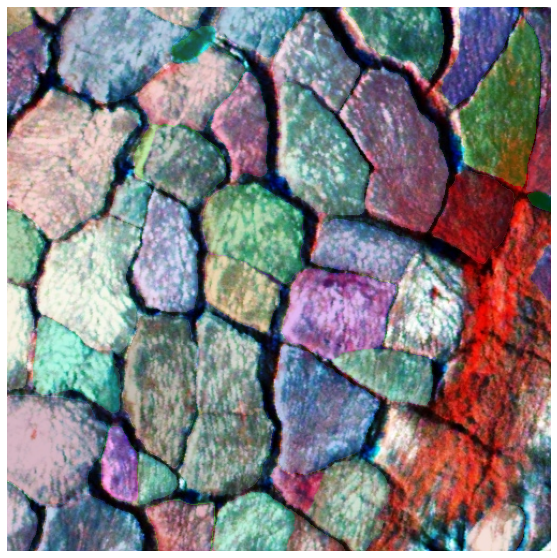

In [10]:
sam.generate(image, output="masks.tif", foreground=True, unique=True)
sam.show_anns(axis="off", alpha=0.3, output="annotations.tif")

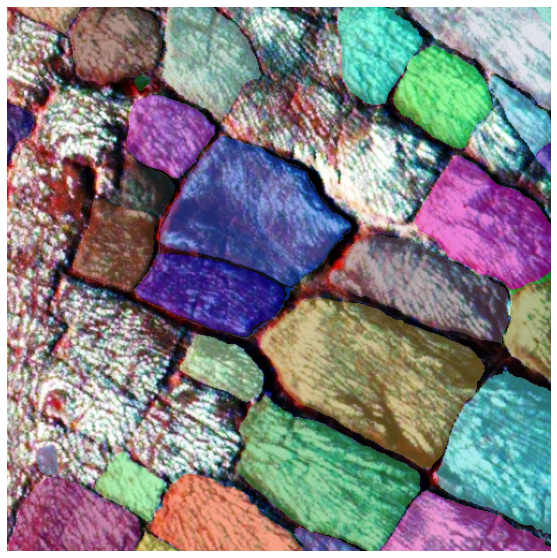

In [13]:
image = imagePath+'FID_1111_Polygon_2.jpg'

sam.generate(image, output="masks.tif", foreground=True, unique=True)
sam.show_anns(axis="off", alpha=0.5, output="annotations.tif")

## Generate masks for all images and Display 
by segmenting all unique objects and show them on top of the original image opacity--> alpha

In [ ]:
import os
# Get the list of all files and directories
file_list = os.listdir(imagePath)
file_list.sort()
#print("Files and directories in '", imagePath, "' :") 
#prints all files
#print(file_list)

#imageName = 'FID_1123_Polygon_2.jpg'

skip_l={15,43,65,106,107,108}
for i in range(len(file_list)):
#for i in {2,14,53,54,91}:
#for i in {29,48,51,90,91,93}:
#for i in {0,1,2,3}:
    if i not in skip_l:
        imageName=file_list[i]
        imageFilePath = imagePath + imageName
        image = imageFilePath
        output_file=imageName+".tif"
        print(i,output_file[:-3])
        imageTitle=str(i)+":"+imageName
        sam.generate(image, output=output_file, foreground=False, unique=True)
        sam.show_anns(axis="off", alpha=0.5, output="annotations.tif",title=imageTitle)

## Point Prompts for Segmentation 

### Prompting with marked polygons
This is an attempt to prompt SAM with marked polyfons or to use prompter such as Mask-RCNN identfy the masks and then use the high confidence masks to improve the segmentation/classification

### Start with the groundtruth polygons

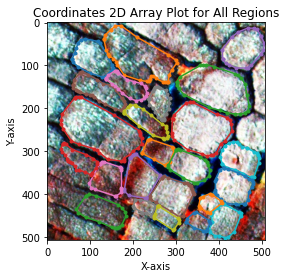

Number of regions in selected file: 24


In [5]:
import json
import matplotlib.pyplot as plt

%matplotlib inline

# Specify the file path
iwps=imagePath+'via_region_data.json'
# Read the content of the file
with open(iwps, 'r') as file:
    json_content = file.read()

# Load the JSON data into a Python dictionary
data_dict = json.loads(json_content)

# give file name to use from the file path
given_filename = "FID_1135_Polygon_2.jpg"

# Search for the key with the given file name
matching_key = None

for key, value in data_dict.items():
    if value["filename"] == given_filename:
        matching_key = key
        break

# Get the masked regions from the data dict (jason file) 
regions = data_dict[matching_key]["regions"]

# Plot all regions to check and see how good the ground truth is
plt.figure()

for region in regions:
    # Extract the coordinates for the current region
    region_coordinates_x = region["shape_attributes"]["all_points_x"]
    region_coordinates_y = region["shape_attributes"]["all_points_y"]

    # Convert the coordinates to a 2D array
    coordinates_2d_array = list(zip(region_coordinates_x, region_coordinates_y))

    # Unzip the coordinates for plotting
    x, y = zip(*coordinates_2d_array)

    # Plot the coordinates for the current region
    plt.plot(x, y, marker='.', linestyle='-', label=region["region_attributes"]["object_name"])

#plt.legend(loc='upper right')

plt.title("Coordinates 2D Array Plot for All Regions")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
#plt.legend()

image=imagePath+given_filename
img2 = plt.imread(image)
plt.imshow(img2)
plt.show()

print("Number of regions in selected file:",len(regions))

### Fill the regions with points to generate the prompts

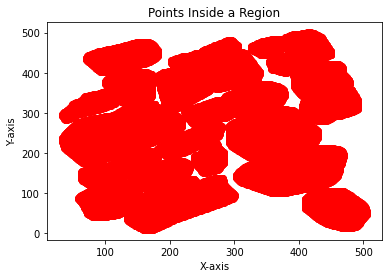

Size of all points inside regions 133105


In [6]:
from shapely.geometry import Point, Polygon
target_region_index = -1
all_points_inside_regions=[]
for target_region_index in range(len(regions)) :
#for target_region_index in {0,1,2,3,4}:
    target_region = regions[target_region_index]

    # Extract the coordinates for the target region
    region_coordinates_x = target_region["shape_attributes"]["all_points_x"]
    region_coordinates_y = target_region["shape_attributes"]["all_points_y"]

    # Create a Polygon object from the region coordinates
    polygon = Polygon(zip(region_coordinates_x, region_coordinates_y))

    # Generate points inside the polygon
    min_x, max_x = min(region_coordinates_x), max(region_coordinates_x)
    min_y, max_y = min(region_coordinates_y), max(region_coordinates_y)

    step = 1  # Adjust the step size as needed smaller to get smoother boundaries
    points_inside_region = [(x, y) for x in range(int(min_x), int(max_x) + 1, step) for y in range(int(min_y), int(max_y) + 1, step) if Point(x, y).within(polygon)]

    # Unzip the coordinates for plotting
    x_inside, y_inside = zip(*points_inside_region)

    # Plot the points inside the region
    #plt.plot(region_coordinates_x + [region_coordinates_x[0]], region_coordinates_y + [region_coordinates_y[0]], marker='o', linestyle='-', label="Target Region")
    plt.scatter(x_inside, y_inside, color='red', label="Points Inside Target Region")

    all_points_inside_regions.extend(points_inside_region)
    
plt.title("Points Inside a Region")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
#plt.legend()
plt.show()
print("Size of all points inside regions",len(all_points_inside_regions))

### Reduce the number of prompts
With too many prompts SAM was running out ot of memory. Redcue X% of points.

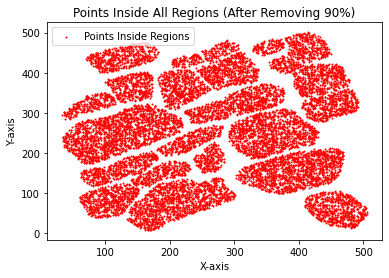

In [14]:
import random
percentage_to_remove = 90
num_points_to_remove = int(len(all_points_inside_regions) * (percentage_to_remove / 100))
random.shuffle(all_points_inside_regions)
all_points_inside_regions = all_points_inside_regions[num_points_to_remove:]

x_inside, y_inside = zip(*all_points_inside_regions)
plt.scatter(x_inside, y_inside, color='red', label="Points Inside Regions",s=1)

plt.title("Points Inside All Regions (After Removing 90%)")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.legend()
plt.show()

point_coords=all_points_inside_regions

### Clear GPU memory if required

In [8]:
import torch
# Clear GPU memory
torch.cuda.empty_cache()

### Load the SAM model
with automatic=false as we are going to provide prompts

In [12]:
sam = SamGeo(
    model_type="vit_h",
    checkpoint="sam_vit_h_4b8939.pth",
    automatic=False,
    sam_kwargs=None,
)

### Use SAM to predict masks
with prompts from ground truth (Cheating to just check viability)

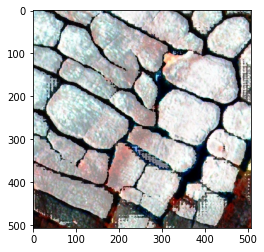

In [15]:
imagePath = '/work/09208/asperera/ls6/DATA/dataset_00_to_06/test/'
image = imagePath+'FID_1135_Polygon_2.jpg'
sam.set_image(image)

#print(point_coords)
sam.predict(point_coords, point_labels=1, output="mask4.tif")
import matplotlib.pyplot as plt
img = plt.imread('mask4.tif')
img2 = plt.imread(image)
plt.imshow(img2)
plt.imshow(img,alpha=0.5)
plt.show() 

### Attempt to give prompts from the MaskRCNN

## Experimenting with parameter for the model. Only works for automatic mode.

                points_per_side: Optional[int] = 32,
                points_per_batch: int = 64,
                pred_iou_thresh: float = 0.88,
                stability_score_thresh: float = 0.95,
                stability_score_offset: float = 1.0,
                box_nms_thresh: float = 0.7,
                crop_n_layers: int = 0,
                crop_nms_thresh: float = 0.7,
                crop_overlap_ratio: float = 512 / 1500,
                crop_n_points_downscale_factor: int = 1,
                point_grids: Optional[List[np.ndarray]] = None,
                min_mask_region_area: int = 0,
                output_mode: str = "binary_mask",
               
        Arguments:
          model (Sam): The SAM model to use for mask prediction.
          points_per_side (int or None): The number of points to be sampled
            along one side of the image. The total number of points is
            points_per_side**2. If None, 'point_grids' must provide explicit
            point sampling.
          points_per_batch (int): Sets the number of points run simultaneously
            by the model. Higher numbers may be faster but use more GPU memory.
          pred_iou_thresh (float): A filtering threshold in [0,1], using the
            model's predicted mask quality.
          stability_score_thresh (float): A filtering threshold in [0,1], using
            the stability of the mask under changes to the cutoff used to binarize
            the model's mask predictions.
          stability_score_offset (float): The amount to shift the cutoff when
            calculated the stability score.
          box_nms_thresh (float): The box IoU cutoff used by non-maximal
            suppression to filter duplicate masks.
          crop_n_layers (int): If >0, mask prediction will be run again on
            crops of the image. Sets the number of layers to run, where each
            layer has 2**i_layer number of image crops.
          crop_nms_thresh (float): The box IoU cutoff used by non-maximal
            suppression to filter duplicate masks between different crops.
          crop_overlap_ratio (float): Sets the degree to which crops overlap.
            In the first crop layer, crops will overlap by this fraction of
            the image length. Later layers with more crops scale down this overlap.
          crop_n_points_downscale_factor (int): The number of points-per-side
            sampled in layer n is scaled down by crop_n_points_downscale_factor**n.
          point_grids (list(np.ndarray) or None): A list over explicit grids
            of points used for sampling, normalized to [0,1]. The nth grid in the
            list is used in the nth crop layer. Exclusive with points_per_side.
          min_mask_region_area (int): If >0, postprocessing will be applied
            to remove disconnected regions and holes in masks with area smaller
            than min_mask_region_area. Requires opencv.
          output_mode (str): The form masks are returned in. Can be 'binary_mask',
            'uncompressed_rle', or 'coco_rle'. 'coco_rle' requires pycocotools.
            For large resolutions, 'binary_mask' may consume large amounts of
            memory.
        """
        
        Initial params that worked for  FID_1123_Polygon_2.jpg
        sam_params={"points_per_batch":64,
            "pred_iou_thresh":0.6,
            "min_mask_region_area":1,
           }

In [2]:
import os
import leafmap
from samgeo import SamGeo, tms_to_geotiff

/home1/09208/asperera/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
sam_params={
            #"points_per_side":32,
            #"points_per_batch":64,
            #"pred_iou_thresh":0.88,
            #"box_nms_thresh":0.7, #0.7
            #"min_mask_region_area":10, #0
      
            "points_per_side":56,#points_per_side: Optional[int] = 32,
            "points_per_batch":64,#points_per_batch: int = 64,
            "pred_iou_thresh":0.9,#pred_iou_thresh: float = 0.88,
            "stability_score_thresh":0.9,#stability_score_thresh: float = 0.95,
            "stability_score_offset":1.0,#stability_score_offset: float = 1.0,
            "box_nms_thresh":0.7,#box_nms_thresh: float = 0.7,
            "crop_n_layers":0, #crop_n_layers: int = 0,
            "crop_nms_thresh":0.7, #crop_nms_thresh: float = 0.7,
            "crop_overlap_ratio":512/1500, #crop_overlap_ratio: float = 512 / 1500,
            "crop_n_points_downscale_factor":1, #crop_n_points_downscale_factor: int = 1,
            #point_grids: Optional[List[np.ndarray]] = None,
            "min_mask_region_area":30,#min_mask_region_area: int = 0,
            "output_mode":"binary_mask",#output_mode: str = "binary_mask",  
           }
print(sam_params)

sam = SamGeo(
    model_type="vit_h",
    checkpoint="sam_vit_h_4b8939.pth",
    automatic=True,
    device=None,
    #min_mask_region_area=0,
    sam_kwargs=sam_params,
    #sam_kwargs=None,
    #sam_kwargs=None
)

{'points_per_side': 56, 'points_per_batch': 64, 'pred_iou_thresh': 0.9, 'stability_score_thresh': 0.9, 'stability_score_offset': 1.0, 'box_nms_thresh': 0.7, 'crop_n_layers': 0, 'crop_nms_thresh': 0.7, 'crop_overlap_ratio': 0.3413333333333333, 'crop_n_points_downscale_factor': 1, 'min_mask_region_area': 30, 'output_mode': 'binary_mask'}


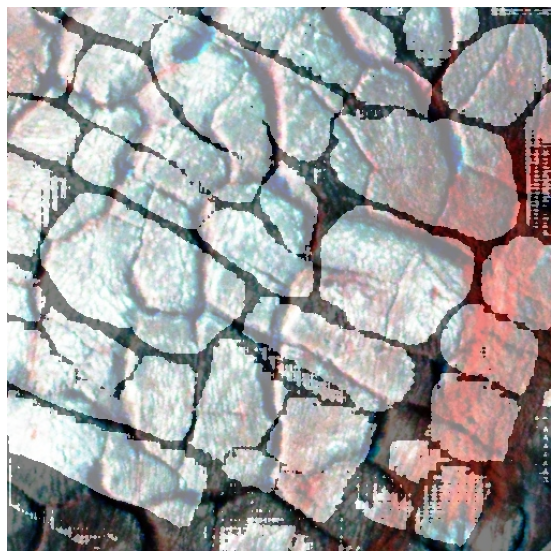

In [14]:
import matplotlib.pyplot as plt
import os

imageName = 'FID_1123_Polygon_2.jpg'

imageFilePath = imagePath + imageName
image = imageFilePath
output_file=imageName+".tif"
imageTitle=str(i)+":"+imageName
sam.generate(image, output=output_file, foreground=False, unique=True)
sam.show_anns(axis="off", alpha=0.5, output="annotations.tif",title=imageTitle)

img = plt.imread('mask4.tif')

img2 = plt.imread(imageFilePath)
plt.imshow(img2)
plt.imshow(img,alpha=0.5,cmap="Greens")
plt.show()
